# Problématique 

Code permettant d'entrainer un modèle de reconnaissance text manuscrit.


# Import

In [3]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import re
from os.path import exists
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import string


import letter_detection_utils as ld_util
import preprocessing as pp
import ressources as rss
import rendering as rd


In [39]:
# Pour recharger les libs pendant les devs
from importlib import reload 
reload(ld_util)
reload(pp)
reload(rss)
reload(rd)

<module 'rendering' from '/Users/davidbeda/Python/Datascientest/projet_OCR_code/OCRpyMAN/notebooks/rendering.py'>

# Chargement du dataframe

In [4]:
# initialisation des variables globales
rss.init()

In [33]:
# Chargement avec tensorflow et dataset par batch

dataset_train, dataset_test, X_test, y_test = ld_util.get_dataset()

dataset_train_canny, dataset_test_canny, X_test_canny, y_test_canny = ld_util.get_dataset(canny=True)

/Users/davidbeda/Python/Datascientest/projet_OCR_code/OCRpyMAN/notebooks/letter_detection_utils.py:52: UserWarning: Creating resources inside a function passed to Dataset.map() is not supported. Create each resource outside the function, and capture it inside the function to use it.
  dataset_train = dataset_train.map(process_trancription)
/Users/davidbeda/Python/Datascientest/projet_OCR_code/OCRpyMAN/notebooks/letter_detection_utils.py:55: UserWarning: Creating resources inside a function passed to Dataset.map() is not supported. Create each resource outside the function, and capture it inside the function to use it.
  dataset_test = dataset_test.map(process_trancription)
/Users/davidbeda/Python/Datascientest/projet_OCR_code/OCRpyMAN/notebooks/letter_detection_utils.py:52: UserWarning: Creating resources inside a function passed to Dataset.map() is not supported. Create each resource outside the function, and capture it inside the function to use it.
  dataset_train = dataset_train.ma

In [41]:
# PROPOSITION DB : initialisation d'un iterator pour afficher différents batchs

iterator = iter(dataset_train)

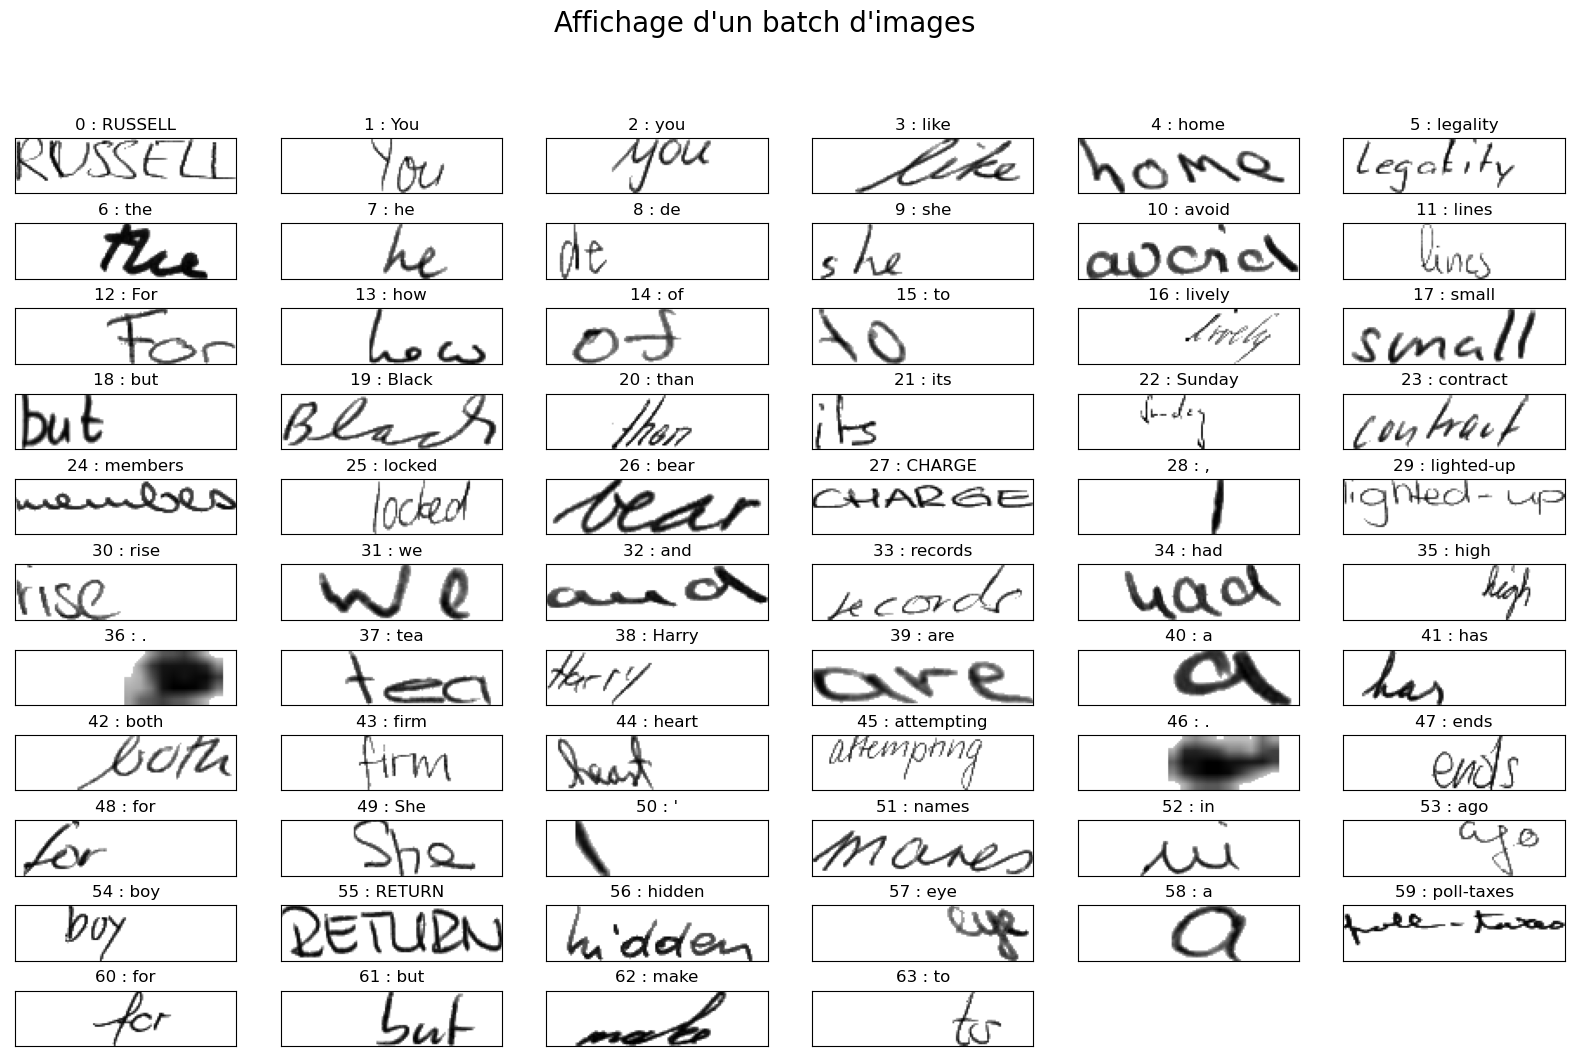

In [42]:
# PROPOSITION DB : lecture des 64 images d'un bacth (le prochain) du dataset d'entrainement

x,y = iterator.get_next()
rd.show_iterator_batch(x,y)

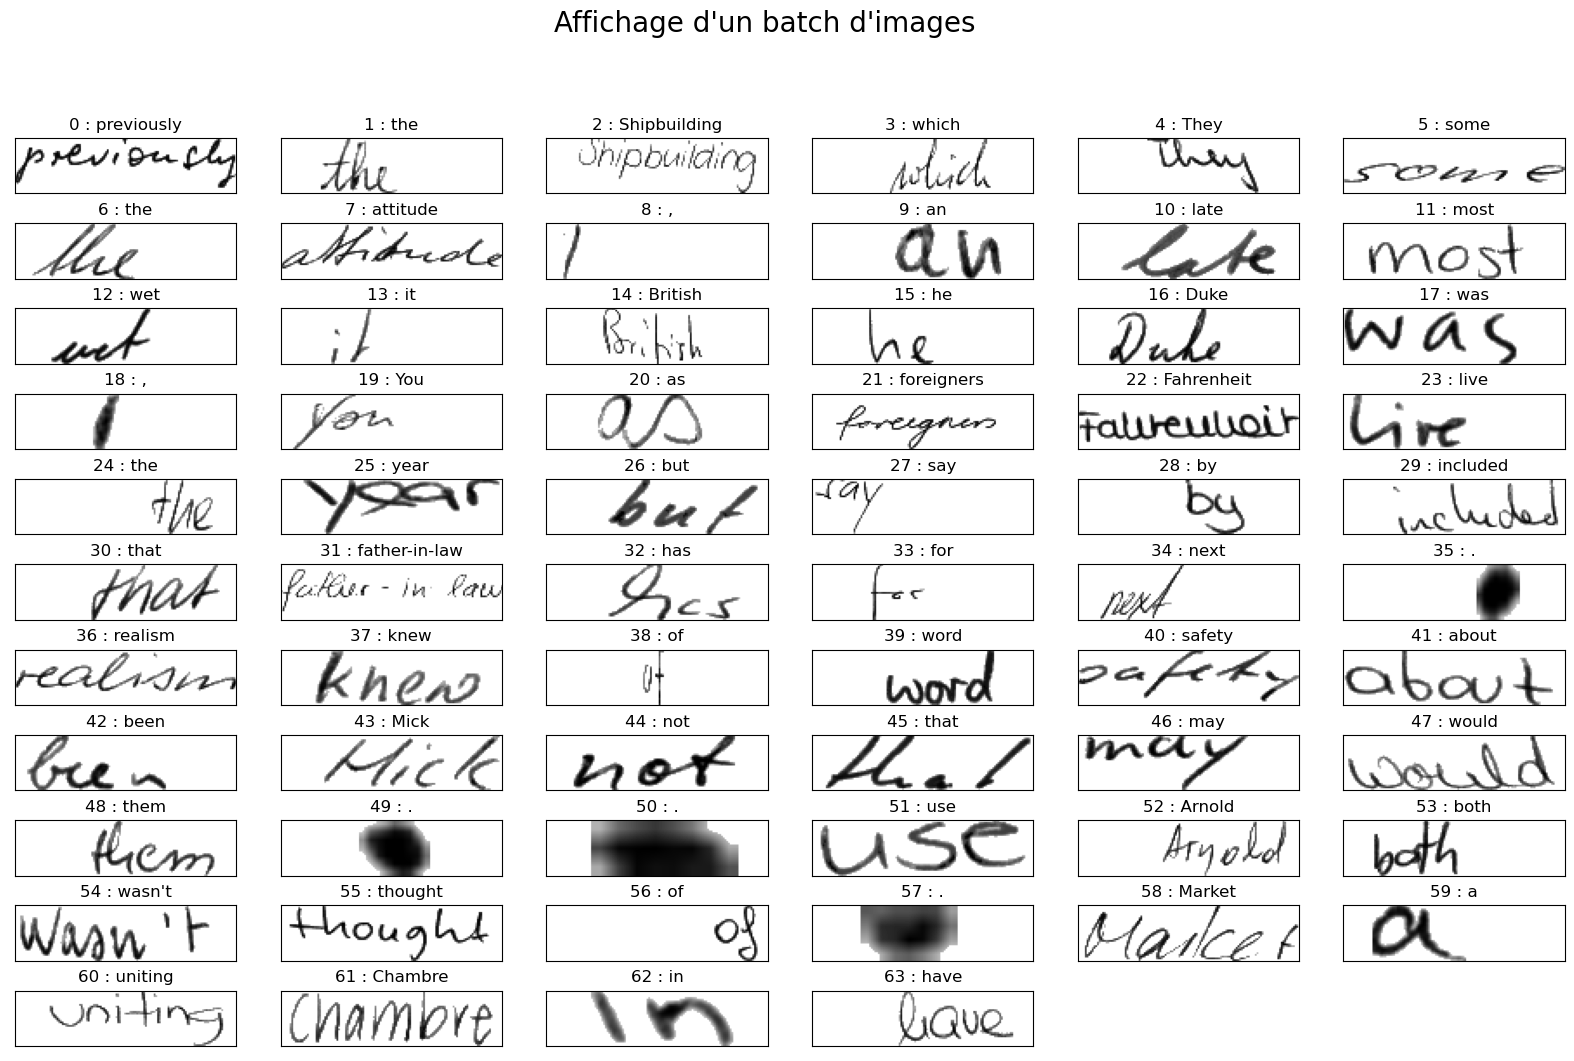

In [27]:
# PROPOSITION DB : lecture des 64 images d'un bacth (le prochain) du dataset d'entrainement
 
x,y = iterator.get_next()

lin = 11
col = 6

#liste_i = np.random.randint(0,64, np.min([lin*col,64]))
liste_i = range(64)
fig = plt.figure(figsize=(20,12))

for j in range(len(liste_i)):
    i = liste_i[j]
    # préparation de l'image
    img = x[i]
    #img = tf.transpose(img, perm=[1,0,2])
    # préparation des labels
    text = ld_util.decode_codes(y, rss.charList)
    text = tf.sparse.to_dense(text).numpy().astype(str)
    liste_label = list(map(lambda x: ''.join(x), text))
    
    fig.add_subplot(lin,col,j+1)
    plt.imshow(img,cmap='gray')
    plt.title(str(i)+' : '+str(liste_label[i]))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.suptitle('Affichage d\'un batch d\'images', size = 20)
    ;

In [376]:
### TEST DB

scale = .8

#print(tf.random.uniform([1], 0, 1))
stretch = scale*(tf.random.uniform([1], 0, 1)[0] - 0.3) # -0.5 .. +0.5
print(stretch)

#w_stretched = tf.maximum(int(float(img_original_size[0]) * (1 + stretch)), 1) # random width, but at least 1
#img = tf.image.resize(img, (w_stretched, img_original_size[1])) # stretch horizontally by factor 0.5 .. 1.5



tf.Tensor(0.04167161, shape=(), dtype=float32)


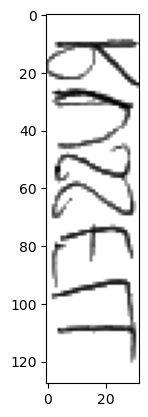

In [377]:
x, y = next(iter(dataset_train_canny))
x[0].shape

tmp = x[0]
# tmp = tf.squeeze(tmp, axis=2)
# tmp = np.swapaxes(tmp, 0, 1)
# tmp = tmp.reshape(128,32)
plt.imshow(tmp , cmap='gray');  # .reshape(rss.img_size)



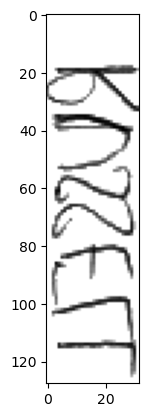

In [378]:
xx, yy = next(iter(dataset_train))
xx[0].shape

tmpp = xx[0]
plt.imshow(tmpp , cmap='gray');  # .reshape(rss.img_size)

In [57]:
(dataset_train_canny)


<MapDataset shapes: ((None, None, None, 1), (None, None)), types: (tf.float32, tf.int32)>

In [ ]:
### TEST DB : Affichage de quelques mots aléatoires avec et sans le traitement du dataset_train

lines = 4

liste_i = np.random.randint(0,df.shape[0], lines*cols)
fig = plt.figure(figsize=(20,10))

for j in range(len(liste_i)):
    i = liste_i[j]
    fig.add_subplot(lines,cols,j+1)
    plt.imshow(plt.imread(df.word_img_path.iloc[i]),cmap='gray')
    plt.title(str(i)+' : '+str(df.transcription.iloc[i]))
    plt.axis('off');

# Model RNN

### Création Modèle

In [41]:
from tensorflow.keras.layers import GRU, Bidirectional, Dense, Lambda
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, LeakyReLU, Dropout

model = tf.keras.Sequential()

############
# Layer 1
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='SAME', input_shape = (128, 32, 1)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Layer 2
model.add(Conv2D(filters=64, kernel_size=(5,5), padding='SAME'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Layer 3
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='SAME'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(1,2), strides=(1,2)))

# Layer 4
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='SAME'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(1,2), strides=(1,2)))

# Layer 5
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='SAME'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(1,2), strides=(1,2)))
#####################


# Remove axis 2
model.add(Lambda(lambda x :tf.squeeze(x, axis=2)))
numHidden = 256
# Bidirectionnal RNN
model.add(Bidirectional(GRU(numHidden, return_sequences=True)))
model.add(Dense(100))
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 128, 32, 32)       832       
                                                                 
 batch_normalization_15 (Bat  (None, 128, 32, 32)      128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 128, 32, 32)       0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 64, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 16, 64)        51264     
                                                                 
 batch_normalization_16 (Bat  (None, 64, 16, 64)      

In [42]:
class CTCLoss(tf.keras.losses.Loss):
    def __init__(self, logits_time_major=False, reduction=tf.keras.losses.Reduction.SUM, name='ctc'):
        super().__init__(reduction=reduction, name=name)
        self.logits_time_major = logits_time_major

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        logit_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        label_length = tf.fill([tf.shape(y_true)[0]], tf.shape(y_true)[1])
        loss = tf.nn.ctc_loss(
            labels=y_true,
            logits=y_pred,
            label_length=label_length,
            logit_length=logit_length,
            logits_time_major=self.logits_time_major,
            blank_index=-1)
        return tf.reduce_mean(loss)


early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tmp_model', 
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch'
)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss=CTCLoss(), optimizer=optimizer)
history = model.fit(
    dataset_train,
    validation_data=dataset_test,
    callbacks=[
        early_stop_callback,
        checkpoint_callback
    ],
    epochs=10
)

Epoch 1/10
1285/1285 [==============================] - ETA: 0s - loss: 13.5688

INFO:tensorflow:Assets written to: tmp_model\assets


INFO:tensorflow:Assets written to: tmp_model\assets


1285/1285 [==============================] - 2258s 2s/step - loss: 13.5688 - val_loss: 11.9347
Epoch 2/10
1285/1285 [==============================] - ETA: 0s - loss: 10.8447

INFO:tensorflow:Assets written to: tmp_model\assets


INFO:tensorflow:Assets written to: tmp_model\assets


1285/1285 [==============================] - 1905s 1s/step - loss: 10.8447 - val_loss: 11.2329
Epoch 3/10
1285/1285 [==============================] - ETA: 0s - loss: 9.5762

INFO:tensorflow:Assets written to: tmp_model\assets


INFO:tensorflow:Assets written to: tmp_model\assets


1285/1285 [==============================] - 1795s 1s/step - loss: 9.5762 - val_loss: 9.2284
Epoch 4/10
1285/1285 [==============================] - ETA: 0s - loss: 8.7984

INFO:tensorflow:Assets written to: tmp_model\assets


INFO:tensorflow:Assets written to: tmp_model\assets


1285/1285 [==============================] - 1547s 1s/step - loss: 8.7984 - val_loss: 8.7660
Epoch 5/10
1285/1285 [==============================] - 1456s 1s/step - loss: 8.2637 - val_loss: 9.0664
Epoch 6/10
1285/1285 [==============================] - ETA: 0s - loss: 7.8468

INFO:tensorflow:Assets written to: tmp_model\assets


INFO:tensorflow:Assets written to: tmp_model\assets


1285/1285 [==============================] - 1647s 1s/step - loss: 7.8468 - val_loss: 8.5288
Epoch 7/10
1285/1285 [==============================] - 1792s 1s/step - loss: 7.5247 - val_loss: 8.8260
Epoch 8/10
1285/1285 [==============================] - ETA: 0s - loss: 7.2456

INFO:tensorflow:Assets written to: tmp_model\assets


INFO:tensorflow:Assets written to: tmp_model\assets


1285/1285 [==============================] - 1806s 1s/step - loss: 7.2456 - val_loss: 7.4784
Epoch 9/10
1285/1285 [==============================] - ETA: 0s - loss: 7.0323

INFO:tensorflow:Assets written to: tmp_model\assets


INFO:tensorflow:Assets written to: tmp_model\assets


1285/1285 [==============================] - 1665s 1s/step - loss: 7.0323 - val_loss: 7.2993
Epoch 10/10
1285/1285 [==============================] - 1617s 1s/step - loss: 6.8368 - val_loss: 7.4703


In [58]:
with open('history.pickle', 'wb') as file_pi:
     pickle.dump(history.history, file_pi)

with open('history.pickle', "rb") as file_pi:
    history = pickle.load(file_pi)

In [43]:
x, y = next(iter(dataset_train))
x.shape


TensorShape([64, 128, 32, 1])

In [59]:
y_pred = model.predict(dataset_test)


143/143 [==============================] - 89s 592ms/step


NameError: name 'utils' is not defined

In [72]:
predicted_transcriptions = ld_util.greedy_decoder(y_pred, rss.charList)
list(zip(predicted_transcriptions, y_test[:10]))

[('on', 'on'),
 ('masaly', 'conveniently'),
 ('it', 'not'),
 ('in', 'in'),
 ('He', 'He'),
 ('of', 'of'),
 (',', ','),
 ('is', 'is'),
 ('pust', 'just'),
 ('in', 'in')]